# PBO learnt on several iterations and one weigth one the chain walk environment

## Define parameters

In [1]:
%load_ext autoreload
%autoreload 2

import jax

# keys
seed = 1
key = jax.random.PRNGKey(seed)
env_key, key = jax.random.split(key)
shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 4)

# Box over states and actions
n_states = 10
n_actions = 2
sucess_probability = 0.9
gamma = 0.8

# Weights collection
n_weights = 1
filtering_weights = True

# PBO trainings
max_bellman_iterations = 5
add_infinity = False
# importance_iteration = [0.01, 0.05, 0.1, 0.5, 1, 5]
importance_iteration = [1] * (max_bellman_iterations + 1)  

## Linear PBO
tolerance = 0.00001
max_steps = 1000
batch_size_samples = 20
batch_size_weights = n_weights
learning_rate = {"first": 0.001, "last": 0.00005, "duration": max_steps}

## Optimal linear PBO
tolerance_optimal = 1e-5
max_steps_optimal = 5000
batch_size_weights_optimal = n_weights
learning_rate_optimal = {"first": 0.001, "last": 0.00005, "duration": max_steps_optimal}

# Visualisation
plot_freq = 2
sleeping_time = 0

## Define environment

In [2]:
import numpy as np

from pbo.environment.chain_walk import ChainWalkEnv

states = np.arange(n_states)
actions = np.arange(n_actions)
states_boxes = (np.arange(n_states + 1 + 1) - 0.5)[:-1]
actions_boxes = (np.arange(n_actions + 1 + 1) - 0.5)[:-1]

env = ChainWalkEnv(env_key, n_states, sucess_probability, gamma)

## Collect samples

### Samples on the mesh

In [3]:
import jax.numpy as jnp

from pbo.sample_collection.replay_buffer import ReplayBuffer


n_samples = n_states * 2
replay_buffer = ReplayBuffer()

for state in states:
    for action in actions:
        env.reset(jnp.array([state]))
        next_state, reward, _, _ = env.step(jnp.array([action]))

        replay_buffer.add(jnp.array([state]), jnp.array([action]), reward, next_state)

replay_buffer.cast_to_jax_array()

### Visualize samples

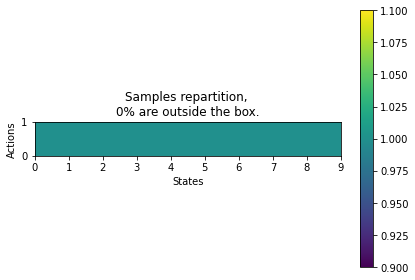

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.state_action_mesh import StateActionMesh


samples_count, n_outside_boxes = count_samples(replay_buffer, states_boxes, actions_boxes)
samples_visu_mesh = StateActionMesh(states, actions, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)

## Optimal Q function

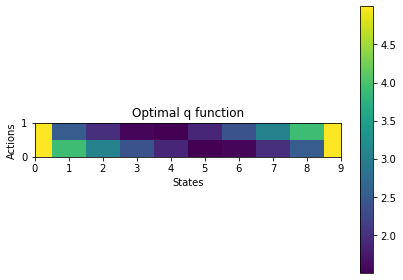

In [5]:
optimal_q = env.optimal_Q_mesh()

q_visu_mesh = StateActionMesh(states, actions, sleeping_time)

q_visu_mesh.set_values(optimal_q)
q_visu_mesh.show("Optimal q function")

## Build q network

In [6]:
from pbo.networks.q import TableQ


q = TableQ(
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    n_states=n_states,
    n_actions=n_actions,
)

## Collect weights

### Random init weights

In [7]:
from pbo.weights_collection.weights_buffer import WeightsBuffer


weights_buffer = WeightsBuffer()

while len(weights_buffer) < n_weights:
    weights = q.random_init_weights()
    if not filtering_weights or weights.max() < 1 / (1 - gamma):
        weights_buffer.add(weights)

weights_buffer.cast_to_jax_array()

## Build the PBOs network and the dataloaders

In [8]:
from pbo.networks.learnable_pbo import LinearPBO, LinearPBOOnWeights
from pbo.networks.optimal_pbo import OptimalTablePBO
from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)

data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
data_loader_weights_optimal = WeightsDataLoader(weights_buffer, batch_size_weights_optimal, shuffle_key)

pbo = LinearPBO(q, max_bellman_iterations, add_infinity, importance_iteration, pbo_network_key, learning_rate)
pbo_optimal = OptimalTablePBO(q, max_bellman_iterations, add_infinity, importance_iteration, env.apply_bellman_operator, optimal_q)
pbo_optimal_linear = LinearPBOOnWeights(q, max_bellman_iterations, add_infinity, importance_iteration, pbo_network_key, learning_rate_optimal, pbo_optimal)

## Train the optimal linear PBO

In [9]:
linear_l2_grad_norm = float("inf")
iteration = 0

while linear_l2_grad_norm > tolerance_optimal and iteration < max_steps_optimal:
    linear_l2_loss = 0

    data_loader_weights_optimal.shuffle()
    for batch_weights in data_loader_weights_optimal:
        pbo_optimal_linear.params, pbo_optimal_linear.optimizer_state, l2_loss, l2_grad_loss = pbo_optimal_linear.learn_on_batch_on_weights(pbo_optimal_linear.params, pbo.optimizer_state, batch_weights)
        linear_l2_loss += l2_loss

    iteration += 1

    # Visualization
    if iteration % plot_freq == 0:
        linear_l2_grad_norm = 0
        for layers in l2_grad_loss.values():
                for grad in layers.values():
                    linear_l2_grad_norm += np.linalg.norm(grad)

        print("linear l2 loss:", linear_l2_loss, "Linear l2 grad loss:", linear_l2_grad_norm)

linear l2 loss: 8.186836 Linear l2 grad loss: 6.08531928062439
linear l2 loss: 8.059493 Linear l2 grad loss: 5.813024640083313
linear l2 loss: 7.9395905 Linear l2 grad loss: 5.580524206161499
linear l2 loss: 7.8259635 Linear l2 grad loss: 5.376661419868469
linear l2 loss: 7.7181067 Linear l2 grad loss: 5.196031212806702
linear l2 loss: 7.6157517 Linear l2 grad loss: 5.038584351539612
linear l2 loss: 7.51802 Linear l2 grad loss: 4.915475249290466
linear l2 loss: 7.423839 Linear l2 grad loss: 4.828724265098572
linear l2 loss: 7.3323717 Linear l2 grad loss: 4.761351585388184
linear l2 loss: 7.2431273 Linear l2 grad loss: 4.713492512702942
linear l2 loss: 7.155423 Linear l2 grad loss: 4.6831440925598145
linear l2 loss: 7.069023 Linear l2 grad loss: 4.657242298126221
linear l2 loss: 6.983786 Linear l2 grad loss: 4.638187766075134
linear l2 loss: 6.8992243 Linear l2 grad loss: 4.63872754573822
linear l2 loss: 6.8148775 Linear l2 grad loss: 4.6444807052612305
linear l2 loss: 6.7304645 Linear 

## Train PBO

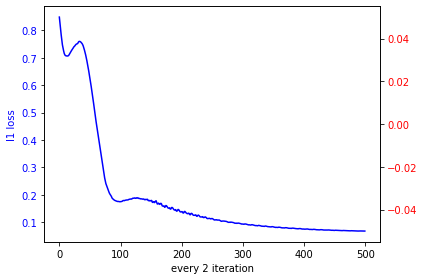

In [10]:
from pbo.utils.shared_axis_plot import shared_axis_plot


# For visualization
full_batch = {
    "state": replay_buffer.states,
    "action": replay_buffer.actions,
    "reward": replay_buffer.rewards,
    "next_state": replay_buffer.next_states,
}
l1_losses = []

iteration = 0
l1_loss = float("inf")
bellman_iterations = jnp.arange(max_bellman_iterations + 1)

while l1_loss > tolerance and iteration < max_steps:
    cumulative_l2_loss = 0
    
    data_loader_weights.shuffle()
    for batch_weights in data_loader_weights:
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            pbo.params, pbo.optimizer_state, l2_loss = pbo.learn_on_batch(pbo.params, pbo.optimizer_state, batch_weights, batch_samples)            
            cumulative_l2_loss += l2_loss

    # Visualization
    if iteration % plot_freq == 0:  
        l1_loss = pbo.loss(pbo.params, data_loader_weights.weights, full_batch, ord=1)

        l1_losses.append(l1_loss)

    iteration += 1

shared_axis_plot(l1_losses, np.array(l1_losses) * np.nan, f"every {plot_freq} iteration", "l1 loss")

In [11]:
iterated_weights = weights.copy()

for i in range(max_bellman_iterations):
    iterated_weights = pbo.network.apply(pbo.params, iterated_weights)

In [12]:
jnp.linalg.norm(optimal_q - q.to_params(iterated_weights)["TableQNet"]["table"])

DeviceArray(2.9802103, dtype=float32)

## Performances of the operators

In [13]:
l1_loss_optimal_linear = pbo.l1_loss(pbo_optimal_linear.params, data_loader_weights.weights, full_batch)
l1_loss_optimal = pbo_optimal.l1_loss(pbo, q, data_loader_weights.weights, full_batch, max_bellman_iterations, add_infinity)

print("l1 loss", l1_loss)
print("l1 loss optimal linear", l1_loss_optimal_linear)
print("l1 loss optimal", l1_loss_optimal)

AttributeError: 'LinearPBO' object has no attribute 'l1_loss'

In [ ]:
q_thin = Theoretical3DQ(
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    action_range_on_max=10 * action_range_on_max,
    n_actions_on_max=10 * n_actions_on_max,
)

pbo_thin = LinearPBO(pbo_network_key, q_thin, learning_rate, max_bellman_iterations, add_infinity)

l1_loss_optimal_thin = pbo_optimal.l1_loss(pbo_thin, q_thin, data_loader_weights.weights, full_batch, max_bellman_iterations, add_infinity)

print("l1 loss optimal thin scale", l1_loss_optimal_thin)

## Visualize iterations on weights

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def add_points(ax, points, size, label, color):
    xdata = points[:, 0]
    ydata = points[:, 1]
    zdata = points[:, 2]
    ax.scatter3D(xdata, ydata, zdata, s=size, label=label, color=color)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
sizes = [1, 5, 300, 1000]
colors = ["black", "b", "red", "g"]
iterated_weights = weights_buffer.weights

for iteration in range(4):
    add_points(ax, iterated_weights, sizes[iteration], f"iteration {iteration}", colors[iteration])
    iterated_weights = pbo_optimal(iterated_weights)

ax.set_xlabel('k')
ax.set_xticklabels([])
ax.set_xticks([])

ax.set_ylabel('i')
ax.set_yticklabels([])
ax.set_yticks([])

ax.set_zlabel('m')
ax.set_zlim(-2, 5)

ax.legend()
ax.view_init(0, 0)
fig.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection='3d')

iterated_weights = weights_buffer.weights

for iteration in range(4):
    add_points(ax, iterated_weights, sizes[iteration], f"iteration {iteration}", colors[iteration])
    iterated_weights = pbo_optimal_linear.network.apply(pbo_optimal_linear.params, iterated_weights)

ax.set_xlabel('k')
ax.set_xticklabels([])
ax.set_xticks([])

ax.set_ylabel('i')
ax.set_yticklabels([])
ax.set_yticks([])

ax.set_zlabel('m')
ax.set_zlim(-2, 5)

ax.legend()
ax.view_init(0, 0)
fig.tight_layout()
print("Contracting facteur", jnp.linalg.norm(pbo_optimal_linear.params["LinearPBONet/linear"]["w"], ord=1))

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection='3d')

iterated_weights = weights_buffer.weights

for iteration in range(4):
    add_points(ax, iterated_weights, sizes[iteration], f"iteration {iteration}", colors[iteration])
    iterated_weights = pbo.network.apply(pbo.params, iterated_weights)

ax.set_xlabel('k')
ax.set_xticklabels([])
ax.set_xticks([])

ax.set_ylabel('i')
ax.set_yticklabels([])
ax.set_yticks([])

ax.set_zlabel('m')
ax.set_zlim(-2, 5)

ax.legend()
ax.view_init(0, 0)
fig.tight_layout()
print("Contracting facteur", jnp.linalg.norm(pbo.params["LinearPBONet/linear"]["w"], ord=1))